In [1]:
import os

import numpy as np
np.set_printoptions(suppress=True)
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import LinearLocator
from matplotlib import gridspec
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline

print("Package is ready.")

Package is ready.


In [2]:
plt.rcParams['figure.figsize'] = ((8/2.54), (6/2.54))
plt.rcParams["font.family"] = "Arial"
plt.rcParams["mathtext.default"] = "rm"
plt.rcParams.update({'font.size': 11})
MARKER_SIZE = 15
cmap_m = ["#f4a6ad", "#f6957e", "#fccfa2", "#8de7be", "#86d6f2", "#24a9e4", "#b586e0", "#d7f293"]
cmap = ["#e94d5b", "#ef4d28", "#f9a54f", "#25b575", "#1bb1e7", "#1477a2", "#a662e5", "#c2f442"]

plt.rcParams['axes.spines.top'] = False
# plt.rcParams['axes.edgecolor'] = 
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['ytick.minor.width'] = 1

# 2020 Summer

## Control weight

In [3]:
SW2_df = pd.read_csv('./results/2020_S/SW2_greenhouse.csv', index_col='Unnamed: 0')
SW2_df.index = pd.DatetimeIndex(SW2_df.index)

### Cultivation period

In [4]:
SW2_df = SW2_df.loc['2020-03-05 00:00:00': '2020-07-03 23:59:00']
SW2_df = SW2_df.interpolate()

### Rockwool weight

In [5]:
rockwool_slab = np.array([626, 708, 650, 642])
rockwool_cube = np.array([48, 46, 50, 48, 46])
rockwool = (rockwool_slab + rockwool_cube.mean()*4)/1000
rockwool_mean = rockwool.mean()

### water weight

In [6]:
substrate_volume = (120*12*7.5 + 10*10*6.5*4)/1000
water_w_df = substrate_volume*SW2_df['subs_VWC']/100
SW2_df['water'] = water_w_df

### Calculating aerial weight

In [7]:
SW2_df.loc[:, 'loadcell_1'] = SW2_df.loc[:, 'loadcell_1'] - rockwool_mean
SW2_df.loc[:, 'loadcell_2'] = SW2_df.loc[:, 'loadcell_2'] - rockwool_mean
SW2_df.loc[:, 'loadcell_3'] = SW2_df.loc[:, 'loadcell_3'] - rockwool_mean

### Destructive crop weight

In [8]:
weight_df = pd.read_csv('./results/2020_S/weight.csv', index_col='Unnamed: 0')
weight_df.index = pd.DatetimeIndex(weight_df.index)
weight_df.index = np.append(weight_df.index[:-20], pd.DatetimeIndex(['2020-07-03']*20))
wweight_df = weight_df[['Stem FW', 'Leaf FW', 'petiole FW', 'Idv fruit FW']].sum(axis=1)

### Root DW to FW

In [9]:
roots_DW = np.array([301.25, 293.55, 315.15, 356.45, 341.55, 267.65, 303.55, 231.05, 253.05, 272.35, 334.35])/1000
roots_DW_mean = roots_DW.mean()
rs_ratio_df = pd.DataFrame([0.23255813953488372, 0.14789272030651343, 0.11954022988505748, 0.13678160919540233, 0.2835814088817321], index=weight_df.index.unique(), columns=['RS_ratio'])
DW_sum_df = weight_df[[col for col in weight_df.columns if col.endswith('DW')]].sum(axis=1).groupby(weight_df.index).mean()

In [10]:
roots_df = (DW_sum_df.T * rs_ratio_df.T).T
roots_df.columns = ['root DW']
roots_df['root FW'] = roots_df['root DW']/0.1325
roots_df.index = pd.DatetimeIndex(roots_df.index)
wweight_wr_df = wweight_df.add(roots_df['root FW'])

### Excepting irrigation disturbance

In [11]:
night_df = SW2_df.loc[SW2_df['rad'] <= 0.2, 'loadcell_1':'loadcell_3']

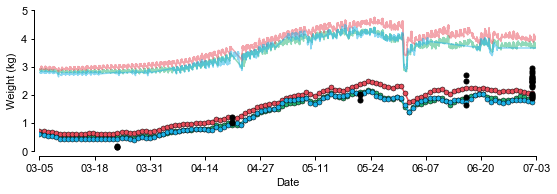

In [12]:
fig = plt.figure(figsize=((8/2.54*2.5), (6/2.54*1.2)))
ax0 = plt.subplot()

ax0.spines['right'].set_visible(False)
ax0.spines['left'].set_position(('outward', 5))
ax0.spines['bottom'].set_position(('outward', 5))

ax0.plot(SW2_df.index, SW2_df['loadcell_1']/4, c=cmap[3], alpha=0.5)
ax0.plot(SW2_df.index, SW2_df['loadcell_2']/4, c=cmap[0], alpha=0.5)
ax0.plot(SW2_df.index, SW2_df['loadcell_3']/4, c=cmap[4], alpha=0.5)

ax0.plot(night_df.resample('1d').mean().index, ((night_df.resample('1d').mean()['loadcell_1'] - SW2_df['water'].resample('1d').mean())/4), '-o', ms=5, mec='k', mew=0.5, c=cmap[3])
ax0.plot(night_df.resample('1d').mean().index, ((night_df.resample('1d').mean()['loadcell_2'] - SW2_df['water'].resample('1d').mean())/4), '-o', ms=5, mec='k', mew=0.5, c=cmap[0])
ax0.plot(night_df.resample('1d').mean().index, ((night_df.resample('1d').mean()['loadcell_3'] - SW2_df['water'].resample('1d').mean())/4), '-o', ms=5, mec='k', mew=0.5, c=cmap[4])

ax0.plot(wweight_df.index, wweight_wr_df/1000, 'o', ms=5, c='k')

ax0.set_xbound(SW2_df.index.min(), SW2_df.index.max())
ax0.xaxis.set_major_locator(LinearLocator(10))
ax0.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

ax0.yaxis.set_major_locator(LinearLocator(6))
ax0.set_ybound(0, 5)

ax0.set_xlabel('Date')
ax0.set_ylabel('Weight (kg)')

fig.tight_layout()
plt.show()

In [13]:
fw_labels = pd.concat([(night_df.resample('1d').mean()['loadcell_1'] - SW2_df['water'].resample('1d').mean())/4,
                       (night_df.resample('1d').mean()['loadcell_2'] - SW2_df['water'].resample('1d').mean())/4,
                       (night_df.resample('1d').mean()['loadcell_3'] - SW2_df['water'].resample('1d').mean())/4], axis=1)
fw_labels.columns = ['CT_1', 'CT_2', 'CT_3']

In [14]:
fw_labels.to_csv('./results/2020_S/fw_labels.csv')

## FR weight

In [15]:
SW2_df = pd.read_csv('./results/2020_S/SW2_FR_greenhouse_origin.csv', index_col='Unnamed: 0')
SW2_df.index = pd.DatetimeIndex(SW2_df.index)
SW2_df.loc[:, 'loadcell_4'] += 13.30
SW2_df.loc[:'2020-04-14 11:20:00', 'loadcell_4'] = np.nan

### Cultivation period

In [16]:
SW2_df = SW2_df.loc['2020-03-05 00:00:00': '2020-07-03 23:59:00']
SW2_df = SW2_df.interpolate()

### Rockwool weight

In [17]:
rockwool_slab = np.array([626, 708, 650, 642])
rockwool_cube = np.array([48, 46, 50, 48, 46])
rockwool = (rockwool_slab + rockwool_cube.mean()*4)/1000
rockwool_mean = rockwool.mean()

### water weight

In [18]:
substrate_volume = (120*12*7.5 + 10*10*6.5*4)/1000
water_w_df = substrate_volume*SW2_df['subs_VWC']/100
SW2_df['water'] = water_w_df

### Calculating aerial weight

In [19]:
SW2_df.loc[:, 'loadcell_4'] = SW2_df.loc[:, 'loadcell_4'] - rockwool_mean

### Destructive crop weight

In [20]:
weight_df = pd.read_csv('./results/2020_S/weight_fr.csv', index_col='Unnamed: 0')
weight_df.index = pd.DatetimeIndex(weight_df.index)
weight_df.index = pd.DatetimeIndex(['2020-07-03']*weight_df.shape[0])
wweight_df = weight_df[['Stem FW', 'Leaf FW', 'petiole FW', 'Idv fruit FW']].sum(axis=1)

### Root DW to FW

In [21]:
roots_DW = np.array([301.25, 293.55, 315.15, 356.45, 341.55, 267.65, 303.55, 231.05, 253.05, 272.35, 334.35])/1000
roots_DW_mean = roots_DW.mean()
rs_ratio_df = pd.DataFrame([0.1840708215607178], index=weight_df.index.unique(), columns=['RS_ratio'])
DW_sum_df = weight_df[[col for col in weight_df.columns if col.endswith('DW')]].sum(axis=1).groupby(weight_df.index).mean()

In [22]:
roots_df = (DW_sum_df.T * rs_ratio_df.T).T
roots_df.columns = ['root DW']
roots_df['root FW'] = roots_df['root DW']/0.1325
roots_df.index = pd.DatetimeIndex(roots_df.index)
wweight_wr_df = wweight_df.add(roots_df['root FW'])

### Excepting irrigation disturbance

In [23]:
night_df = SW2_df.loc[SW2_df['rad'] <= 0.2, 'loadcell_4':'loadcell_4']

In [24]:
night_df.dropna()

,loadcell_4
2020-04-14 19:09:00,12.2631
2020-04-14 19:10:00,12.2631
2020-04-14 19:11:00,12.2631
2020-04-14 19:12:00,12.2631
2020-04-14 19:13:00,12.2631
...,...
2020-07-03 23:55:00,13.7531
2020-07-03 23:56:00,13.7531
2020-07-03 23:57:00,13.7531
2020-07-03 23:58:00,13.7531


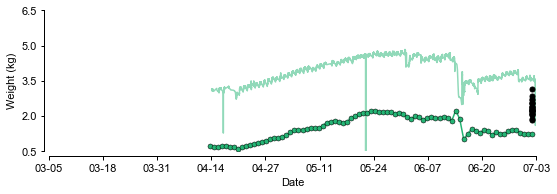

In [25]:
fig = plt.figure(figsize=((8/2.54*2.5), (6/2.54*1.2)))
ax0 = plt.subplot()

ax0.spines['right'].set_visible(False)
ax0.spines['left'].set_position(('outward', 5))
ax0.spines['bottom'].set_position(('outward', 5))

ax0.plot(SW2_df.index, SW2_df['loadcell_4']/4, c=cmap[3], alpha=0.5)

ax0.plot(night_df.resample('1d').mean().index, ((night_df.resample('1d').mean()['loadcell_4'] - SW2_df['water'].resample('1d').mean())/4), '-o', ms=5, mec='k', mew=0.5, c=cmap[3])

ax0.plot(wweight_df.index, wweight_wr_df/1000, 'o', ms=5, c='k')

ax0.set_xbound(SW2_df.index.min(), SW2_df.index.max())
ax0.xaxis.set_major_locator(LinearLocator(10))
ax0.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

ax0.yaxis.set_major_locator(LinearLocator(5))
ax0.set_ybound(0.5, 6.5)

ax0.set_xlabel('Date')
ax0.set_ylabel('Weight (kg)')

fig.tight_layout()
plt.show()

In [26]:
fw_labels = pd.DataFrame(((night_df.resample('1d').mean()['loadcell_4'] - SW2_df['water'].resample('1d').mean())/4), columns=['FR_1'])

In [27]:
fw_labels.to_csv('./results/2020_S/fw_fr_labels.csv')

# 2020 Winter

## Control weight

In [28]:
SW2_df = pd.read_csv('./results/2020_W/SW_CT_greenhouse.csv', index_col='Unnamed: 0')
SW2_df.index = pd.DatetimeIndex(SW2_df.index)

### Cultivation period

In [29]:
SW2_df = SW2_df.loc['2020-08-26 00:00:00': '2021-01-24 23:59:00']
SW2_df = SW2_df.interpolate()

### Rockwool weight

In [30]:
rockwool_slab = np.array([626, 708, 650, 642])
rockwool_cube = np.array([48, 46, 50, 48, 46])
rockwool = (rockwool_slab + rockwool_cube.mean()*3)/1000
rockwool_mean = rockwool.mean()

### water weight

In [31]:
substrate_volume = (120*12*7.5 + 10*10*6.5*3)/1000
water_w_df = substrate_volume*SW2_df['subs_VWC']/100
SW2_df['water'] = water_w_df

### Calculating aerial weight

In [32]:
SW2_df.loc[:, 'loadcell_1'] = SW2_df.loc[:, 'loadcell_1'] - 0.8
SW2_df.loc[:, 'loadcell_2'] = SW2_df.loc[:, 'loadcell_2'] - 0.5
SW2_df.loc[:, 'loadcell_3'] = SW2_df.loc[:, 'loadcell_3'] - 0.8

### Destructive crop weight

In [33]:
weight_df = pd.read_csv('./results/2020_W/ct_weight.csv', index_col='Unnamed: 0')
weight_df.index = pd.DatetimeIndex(weight_df.index)
wweight_df = weight_df[['Stem FW', 'Leaf FW', 'petiole FW', 'Idv fruit FW']].sum(axis=1)

### Root DW to FW

In [34]:
roots_DW = np.array([301.25, 293.55, 315.15, 356.45, 341.55, 267.65, 303.55, 231.05, 253.05, 272.35, 334.35])/1000
roots_DW_mean = roots_DW.mean()
rs_ratio_df = pd.DataFrame([0.23255813953488372, 0.14789272030651343, 0.11954022988505748, 0.13678160919540233, 0.2835814088817321], index=weight_df.index.unique(), columns=['RS_ratio'])
DW_sum_df = weight_df[[col for col in weight_df.columns if col.endswith('DW')]].sum(axis=1).groupby(weight_df.index).mean()

In [35]:
DW_sum_df.loc['2021-01-24'] = 160 # delete later

In [36]:
roots_df = (DW_sum_df.T * rs_ratio_df.T).T
roots_df.columns = ['root DW']
roots_df['root FW'] = roots_df['root DW']/0.1325
roots_df.index = pd.DatetimeIndex(roots_df.index)
wweight_wr_df = wweight_df.add(roots_df['root FW'])

### Excepting irrigation disturbance

In [37]:
night_df = SW2_df.loc[SW2_df['rad'] <= 0.2, 'loadcell_1':'loadcell_3']

In [38]:
wweight_wr_df['2020-09-09'] += 500

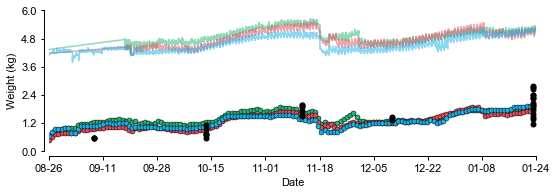

In [39]:
fig = plt.figure(figsize=((8/2.54*2.5), (6/2.54*1.2)))
ax0 = plt.subplot()

ax0.spines['right'].set_visible(False)
ax0.spines['left'].set_position(('outward', 5))
ax0.spines['bottom'].set_position(('outward', 5))

ax0.plot(SW2_df.index, SW2_df['loadcell_1']/3, c=cmap[3], alpha=0.5)
ax0.plot(SW2_df.index, SW2_df['loadcell_2']/3, c=cmap[0], alpha=0.5)
ax0.plot(SW2_df.index, SW2_df['loadcell_3']/3, c=cmap[4], alpha=0.5)

ax0.plot(night_df.resample('1d').mean().index, ((night_df.resample('1d').mean()['loadcell_1'] - SW2_df['water'].resample('1d').mean())/3) - 0.5, '-o', ms=5, mec='k', mew=0.5, c=cmap[3])
ax0.plot(night_df.resample('1d').mean().index, ((night_df.resample('1d').mean()['loadcell_2'] - SW2_df['water'].resample('1d').mean())/3) - 0.5, '-o', ms=5, mec='k', mew=0.5, c=cmap[0])
ax0.plot(night_df.resample('1d').mean().index, ((night_df.resample('1d').mean()['loadcell_3'] - SW2_df['water'].resample('1d').mean())/3) - 0.3, '-o', ms=5, mec='k', mew=0.5, c=cmap[4])

ax0.plot(wweight_df.index, wweight_wr_df/1000, 'o', ms=5, c='k')

ax0.set_xbound(SW2_df.index.min(), SW2_df.index.max())
ax0.xaxis.set_major_locator(LinearLocator(10))
ax0.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

ax0.yaxis.set_major_locator(LinearLocator(6))
ax0.set_ybound(0, 6)

ax0.set_xlabel('Date')
ax0.set_ylabel('Weight (kg)')

fig.tight_layout()
plt.show()

In [40]:
fw_labels = pd.concat([(night_df.resample('1d').mean()['loadcell_1'] - SW2_df['water'].resample('1d').mean())/3-0.5,
                       (night_df.resample('1d').mean()['loadcell_2'] - SW2_df['water'].resample('1d').mean())/3-0.5,
                       (night_df.resample('1d').mean()['loadcell_3'] - SW2_df['water'].resample('1d').mean())/3-0.3], axis=1)
fw_labels.columns = ['CT_1', 'CT_2', 'CT_3']

In [41]:
fw_labels.to_csv('./results/2020_W/fw_ct_labels.csv')

## 2020 Winter FR Loadcell weight

In [ ]:
SW2_df = pd.read_csv('./results/2020_W/SW_FR_greenhouse.csv', index_col='Unnamed: 0')
SW2_df.index = pd.DatetimeIndex(SW2_df.index)

In [ ]:
# SW2_df = SW2_df.loc['2020-03-05 00:00:00': '2020-07-03 23:59:00']

### rockwool weight

In [ ]:
rockwool_slab = np.array([626, 708, 650, 642])

In [ ]:
rockwool_cube = np.array([48, 46, 50, 48, 46])

In [ ]:
rockwool = (rockwool_slab + rockwool_cube.mean()*3)/1000

In [ ]:
rockwool_mean = rockwool.mean()
print(rockwool_mean)

In [ ]:
rockwool.std()

### rockwool slab weight

### root weight

In [ ]:
roots_DW = np.array([301.25, 293.55, 315.15, 356.45, 341.55, 267.65, 303.55, 231.05, 253.05, 272.35, 334.35])/1000

In [ ]:
roots_DW_mean = roots_DW.mean()
print(roots_DW_mean)

In [ ]:
roots_DW.std()

### water weight

In [ ]:
substrate_volume = (120*12*7.5 + 10*10*6.5*4)/1000

In [ ]:
water_w_df = substrate_volume*SW2_df['subs_VWC']/100

In [ ]:
SW2_df['water'] = water_w_df

In [ ]:
SW2_df = SW2_df.interpolate()

In [ ]:
SW2_df.head()

## 6은 나중에 확인

In [ ]:
SW2_df.loc[:, 'loadcell_4'] = SW2_df.loc[:, 'loadcell_4'] - rockwool_mean + 6

In [ ]:
fig = plt.figure(figsize=((8/2.54*6.2), (6/2.54*3.2)))
ax0 = plt.subplot()

ax0.spines['right'].set_visible(False)
ax0.spines['left'].set_position(('outward', 5))
ax0.spines['bottom'].set_position(('outward', 5))

ax0.plot(SW2_df.index, SW2_df['loadcell_4']/3, c=cmap[3])

ax0.set_xbound(SW2_df.index.min(), SW2_df.index.max())
# ax0.set_xbound(pd.Timestamp('2020-04-20 00:00:00'), pd.Timestamp('2020-04-23 23:59:00'))
ax0.xaxis.set_major_locator(LinearLocator(20))
ax0.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

ax0.yaxis.set_major_locator(LinearLocator(5))
ax0.yaxis.set_minor_locator(LinearLocator(13))
ax0.set_ybound(2, 5)

ax0.set_xlabel('Date')
ax0.set_ylabel('Weight (kg)')

ax0.set_rasterized(True)
fig.tight_layout()
plt.show() 

In [ ]:
fig = plt.figure(figsize=((8/2.54*2.2), (6/2.54*1.2)))
ax0 = plt.subplot()

ax0.spines['right'].set_visible(False)
ax0.spines['left'].set_position(('outward', 5))
ax0.spines['bottom'].set_position(('outward', 5))

ax0.plot(SW2_df.index, SW2_df['subs_VWC'], c=cmap[4])
ax0.plot(SW2_df.index, SW2_df['permit'], c=cmap_m[4])

ax0.set_xbound(SW2_df.index.min(), SW2_df.index.max())
# ax0.set_xbound('2020-03-19 20:00:00', '2020-03-20 03:59:00')
ax0.xaxis.set_major_locator(LinearLocator(10))
ax0.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

ax0.yaxis.set_major_locator(LinearLocator(5))
ax0.yaxis.set_minor_locator(LinearLocator(13))
#ax0.set_ybound(2, 5)

ax0.set_xlabel('Date')

fig.tight_layout()
fig.savefig('./figures/Fig_test.svg', transparent=True, format='svg')
plt.show() 

In [ ]:
fig = plt.figure(figsize=((8/2.54*2.2), (6/2.54*1.2)))
ax0 = plt.subplot()

ax0.spines['right'].set_visible(False)
ax0.spines['left'].set_position(('outward', 5))
ax0.spines['bottom'].set_position(('outward', 5))

ax0.plot(SW2_df.index, SW2_df['loadcell_4'], c=cmap[3], alpha=0.5)

ax0.plot(SW2_df.index, SW2_df['loadcell_4'] - SW2_df['water'], c=cmap[3])

ax0.set_xbound(SW2_df.index.min(), SW2_df.index.max())
ax0.xaxis.set_major_locator(LinearLocator(10))
ax0.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

# ax0.yaxis.set_major_locator(LinearLocator(5))
# ax0.yaxis.set_minor_locator(LinearLocator(13))
# ax0.set_ybound(2, 5)

ax0.set_xlabel('Date')
ax0.set_ylabel('Weight (kg)')

fig.tight_layout()
plt.show() 

## 2020 Winter RB Loadcell weight

In [ ]:
SW2_df = pd.read_csv('./results/2020_W/SW_RB_greenhouse.csv', index_col='Unnamed: 0')
SW2_df.index = pd.DatetimeIndex(SW2_df.index)

In [ ]:
# SW2_df = SW2_df.loc['2020-03-05 00:00:00': '2020-07-03 23:59:00']

### rockwool weight

In [ ]:
rockwool_slab = np.array([626, 708, 650, 642])

In [ ]:
rockwool_cube = np.array([48, 46, 50, 48, 46])

In [ ]:
rockwool = (rockwool_slab + rockwool_cube.mean()*3)/1000

In [ ]:
rockwool_mean = rockwool.mean()
print(rockwool_mean)

In [ ]:
rockwool.std()

### rockwool slab weight

### root weight

In [ ]:
roots_DW = np.array([301.25, 293.55, 315.15, 356.45, 341.55, 267.65, 303.55, 231.05, 253.05, 272.35, 334.35])/1000

In [ ]:
roots_DW_mean = roots_DW.mean()
print(roots_DW_mean)

In [ ]:
roots_DW.std()

### water weight

In [ ]:
substrate_volume = (120*12*7.5 + 10*10*6.5*4)/1000

In [ ]:
water_w_df = substrate_volume*SW2_df['subs_VWC']/100

In [ ]:
SW2_df['water'] = water_w_df

In [ ]:
SW2_df = SW2_df.interpolate()

In [ ]:
SW2_df.head()

## 9는 나중에 확인

In [ ]:
SW2_df.loc[:, 'loadcell_5'] = SW2_df.loc[:, 'loadcell_5'] - rockwool_mean + 9
SW2_df.loc[:, 'loadcell_6'] = SW2_df.loc[:, 'loadcell_6'] - rockwool_mean + 9

In [ ]:
fig = plt.figure(figsize=((8/2.54*6.2), (6/2.54*3.2)))
ax0 = plt.subplot()

ax0.spines['right'].set_visible(False)
ax0.spines['left'].set_position(('outward', 5))
ax0.spines['bottom'].set_position(('outward', 5))

ax0.plot(SW2_df.index, SW2_df['loadcell_5']/3 + 1, c=cmap[3])
ax0.plot(SW2_df.index, SW2_df['loadcell_6']/3 + 1, c=cmap[0])


ax0.set_xbound(SW2_df.index.min(), SW2_df.index.max())
# ax0.set_xbound(pd.Timestamp('2020-04-20 00:00:00'), pd.Timestamp('2020-04-23 23:59:00'))
ax0.xaxis.set_major_locator(LinearLocator(20))
ax0.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

ax0.yaxis.set_major_locator(LinearLocator(5))
ax0.yaxis.set_minor_locator(LinearLocator(13))
ax0.set_ybound(2, 5)

ax0.set_xlabel('Date')
ax0.set_ylabel('Weight (kg)')

ax0.set_rasterized(True)
fig.tight_layout()
plt.show() 

In [ ]:
fig = plt.figure(figsize=((8/2.54*2.2), (6/2.54*1.2)))
ax0 = plt.subplot()

ax0.spines['right'].set_visible(False)
ax0.spines['left'].set_position(('outward', 5))
ax0.spines['bottom'].set_position(('outward', 5))

ax0.plot(SW2_df.index, SW2_df['subs_VWC'], c=cmap[4])
ax0.plot(SW2_df.index, SW2_df['permit'], c=cmap_m[4])

ax0.set_xbound(SW2_df.index.min(), SW2_df.index.max())
# ax0.set_xbound('2020-03-19 20:00:00', '2020-03-20 03:59:00')
ax0.xaxis.set_major_locator(LinearLocator(10))
ax0.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

ax0.yaxis.set_major_locator(LinearLocator(5))
ax0.yaxis.set_minor_locator(LinearLocator(13))
#ax0.set_ybound(2, 5)

ax0.set_xlabel('Date')

fig.tight_layout()
fig.savefig('./figures/Fig_test.svg', transparent=True, format='svg')
plt.show() 

In [ ]:
fig = plt.figure(figsize=((8/2.54*2.2), (6/2.54*1.2)))
ax0 = plt.subplot()

ax0.spines['right'].set_visible(False)
ax0.spines['left'].set_position(('outward', 5))
ax0.spines['bottom'].set_position(('outward', 5))

ax0.plot(SW2_df.index, SW2_df['loadcell_5'], c=cmap[3], alpha=0.5)
ax0.plot(SW2_df.index, SW2_df['loadcell_6'], c=cmap[0], alpha=0.5)

ax0.plot(SW2_df.index, SW2_df['loadcell_5'] - SW2_df['water'], c=cmap[3])
ax0.plot(SW2_df.index, SW2_df['loadcell_6'] - SW2_df['water'], c=cmap[0])

ax0.set_xbound(SW2_df.index.min(), SW2_df.index.max())
ax0.xaxis.set_major_locator(LinearLocator(10))
ax0.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

# ax0.yaxis.set_major_locator(LinearLocator(5))
# ax0.yaxis.set_minor_locator(LinearLocator(13))
# ax0.set_ybound(2, 5)

ax0.set_xlabel('Date')
ax0.set_ylabel('Weight (kg)')

fig.tight_layout()
plt.show() 